In [85]:
import pandas
import os
import matplotlib.pyplot as plt

data_path = 'perf-data'
devices = ['3b+', '3b.']
osses = ["ubuntu64", "rpios32"]
runtimes = ['go', 'js', 'py','native']

In [86]:
flat_files = []
iterations = os.listdir(data_path)

for it in iterations:
    it_files = os.listdir(f"{data_path}/{it}")
    for it_file in it_files:
        flat_files.append(f"{data_path}/{it}/{it_file}")

In [87]:
def pretty_print_data(data, unit='ns'):
    for device in data.keys():
        print(f"{device}:")
        for os in data[device].keys():
            print(f'\t{os}:')
            for runtime in data[device][os].keys():
                converted_data = data[device][os][runtime]
                if converted_data is None:                    
                    continue
                if unit == 'µs':
                    converted_data = converted_data / 1000
                if unit == 'ms':
                    converted_data = converted_data / 1000000
                if unit == 's':
                    converted_data = converted_data / 1000000000
                if unit == '%':
                    converted_data = converted_data * 100
                print(f"\t\t{runtime}: {converted_data} {unit}")

In [88]:
runtime_device_files_total = {}
for device in devices:
    runtime_device_files_total[device] = {}
    device_files = list(filter(lambda file: device in file, flat_files))
    for os in osses:
        runtime_device_files_total[device][os] = {}
        device_os_files = list(filter(lambda file: os in file, device_files))
        for runtime in runtimes:
            runtime_device_files = list(filter(lambda file: runtime in file, device_os_files)) 
            if len(runtime_device_files) <= 0:
                continue
            runtime_device_files_total[device][os][runtime] = runtime_device_files

In [89]:
def getConcatData(files):    
    runtime_data = pandas.DataFrame()
    for file in files:
        data = pandas.read_csv(file)
        runtime_data = runtime_data.append(data, ignore_index=True)
    return runtime_data

runtime_device_data = {}
for device in runtime_device_files_total.keys():
    runtime_device_data[device] = {}
    for os in runtime_device_files_total[device].keys():
        runtime_device_data[device][os] = {}
        for runtime in runtime_device_files_total[device][os].keys():
            runtime_device_data[device][os][runtime] = getConcatData(runtime_device_files_total[device][os][runtime])

## Visualize time per execution

In [90]:
import inspect
def visualize_data(plot_fn, file_name, custom_fn=None, device='3b+', os='ubuntu64'):
    cols = len(iterations)
    rows = len(runtime_device_files_total[device][os].keys())
    cols_headers = ['Iteration {}'.format(col) for col in range(cols)]
    rows_headers = runtime_device_files_total[device][os].keys()
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for idx_runtime, runtime in enumerate(runtime_device_files_total[device][os].keys()):
        for idx_it, it in enumerate(iterations):
            date = pandas.read_csv(runtime_device_files_total[device][os][runtime][idx_it])     
            if custom_fn is not None:
                custom_fn(axes[idx_runtime, idx_it], date)
            else:
                fn = getattr(axes[idx_runtime, idx_it], plot_fn)
                req_args = inspect.getfullargspec(fn)
                if all(item in req_args.args for item in ['x', 'y']):
                    fn(date.index.values.tolist(), date['time (ns)'])
                else:
                    fn(date['time (ns)'])
    for ax, col in zip(axes[0], cols_headers):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows_headers):
        ax.set_ylabel(row, rotation=0, size='large')
    fig.tight_layout()
    plt.savefig(file_name,facecolor='white', transparent=False)
    plt.close()

In [91]:
visualize_data('scatter', 'scatters3b+ubuntu.png')
visualize_data('scatter', 'scatters3b+rpios.png', os='rpios32')
visualize_data('scatter', 'scatters3b.png', device='3b.')

In [58]:
visualize_data('boxplot', 'boxplot.png')

In [ ]:
def hist_plot(ax, date):
    ax.hist(date['time (ns)'], density=True,log=True)
visualize_data('plot', 'normplot.png', hist_plot)

## Data time means (ns)

In [92]:
def map_data(date_manipulation, data=runtime_device_data):
    temp_data = {}
    for device in data.keys():
        temp_data[device] = {}
        for os in data[device].keys():
            temp_data[device][os] = {}
            for runtime in data[device][os].keys():
                temp_data[device][os][runtime] = date_manipulation(data[device][os][runtime],device,os,runtime,data)
    return temp_data

3b+:
	ubuntu64:
		go: 4570250.479177778 ns
		js: 8247462.980244445 ns
		py: 3261947.1746444446 ns
		native: 42683.48628888889 ns
	rpios32:
		js: 12372149.218537778 ns
		native: 25701.920777777777 ns
3b.:
	ubuntu64:
		go: 5151524.89388 ns
		js: 8958540.465733333 ns
		py: 3575884.898853333 ns
		native: 49824.13672888889 ns
	rpios32:
		js: 13443498.048871111 ns
		native: 30103.323928888887 ns
3b+:
	ubuntu64:
		go: 10707.303635522101 %
		js: 19322.374288792278 %
		py: 7642.176069140762 %
		native: 100.0 %
	rpios32:
		js: 48137.06074930751 %
		native: 100.0 %
3b.:
	ubuntu64:
		go: 10339.416259053934 %
		js: 17980.32249806953 %
		py: 7177.013258274827 %
		native: 100.0 %
	rpios32:
		js: 44657.85266978426 %
		native: 100.0 %


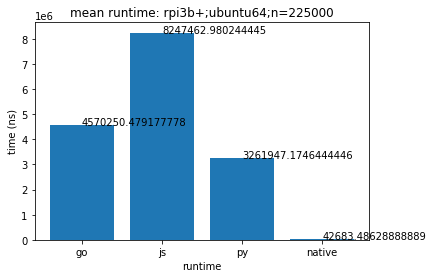

In [93]:
time_field = 'time (ns)'
runtime_device_data_means = map_data(lambda date, device, os, runtime, all_data: date[time_field].mean())
pretty_print_data(runtime_device_data_means, 'ns')

delta_means_rel = map_data(
    lambda date, device, os, runtime, all_data:
    date / all_data[device][os]['native']
        , runtime_device_data_means)
pretty_print_data(delta_means_rel, unit="%")

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('time (ns)')
ax.set_xlabel('runtime')
ax.set_title('mean runtime: rpi3b+;ubuntu64;n=225000')
x = runtime_device_data_means['3b+']['ubuntu64'].keys()
y = runtime_device_data_means['3b+']['ubuntu64'].values()
ax.bar(x, y)
for index, value in enumerate(y):
    plt.text(index, int(value), str(value))

## Data time standard deviations (ns)

In [94]:
time_field = 'time (ns)'
runtime_device_data_stds = map_data(lambda date, device, os, runtime, all_data: date[time_field].std())
pretty_print_data(runtime_device_data_stds, 'ms')

3b+:
	ubuntu64:
		go: 2.524160953178403 ms
		js: 5.81342464970086 ms
		py: 1.4528913005266697 ms
		native: 0.014889705254302422 ms
	rpios32:
		js: 41.38579831069536 ms
		native: 0.03917422269880908 ms
3b.:
	ubuntu64:
		go: 2.845189445467819 ms
		js: 6.368635902409733 ms
		py: 1.5940647578133609 ms
		native: 0.0182328473309366 ms
	rpios32:
		js: 44.775194575832884 ms
		native: 0.044768709584698134 ms


In [25]:
# time.apply(lambda date: date/1000000).max()

0.39218